<a href="https://colab.research.google.com/github/OjasSharma29/Object-Detection/blob/main/G16_NFT_W21_A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NFT-W21-ASSIGNMENT2(G16)

STUDENTS:

BT19CSE028 ESHAN KUMAR JAIN

BT19CSE100 SHARMA OJAS RAJNISH

BT19CSE127 WAGH ABHISHEK SAMBHAJI


# Importing Relevant libraries and Data Sets

The CIFAR-10 dataset
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

In [17]:
from __future__ import print_function
import time
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import numpy as np
import os

#import tensorflow as tf

# Load the CIFAR10 data.

from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [18]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


# Showing a portion of the data set

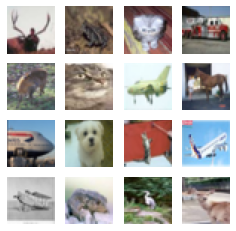

In [19]:
import matplotlib.pyplot as plt # for plotting and stuff
from six.moves import cPickle

dims = 4 # dimension of the image matrix

x = x_train.astype("uint8")

fig, axes = plt.subplots(dims,dims,figsize=(dims,dims))

for i in range(dims):
  for j in range(dims):
    img = np.random.choice(range(len(x)))
    axes[i][j].set_axis_off()
    axes[i][j].imshow(x[img:img+1][0])

In [20]:
x_train.shape, y_train # dimensions of the following

((50000, 32, 32, 3), array([[6],
        [9],
        [9],
        ...,
        [9],
        [1],
        [1]], dtype=uint8))

# Declaring the training parameters

In [21]:
# training parameters for the model

batch_size = 32
epochs = 50
use_augumentation = True
classes = np.unique(y_train).shape[0]
colors = 3
depth = 3 * 6 + 2

# Subtract pixel mean for accuracy improvement

subtract_pixel_mean = True

In [22]:
print(classes)

10


# Function for the learning rate scheduler

LearningRateScheduler class
tf.keras.callbacks.LearningRateScheduler(schedule, verbose=0)
Learning rate scheduler.

At the beginning of every epoch, this callback gets the updated learning rate value from schedule function provided at __init__, with the current epoch and current learning rate, and applies the updated learning rate on the optimizer.

Arguments

schedule: a function that takes an epoch index (integer, indexed from 0) and current learning rate (float) as inputs and returns a new learning rate as output (float).
verbose: int. 0: quiet, 1: update messages.

In [23]:
# learning rate changer
def lr_schedule(epochs):
  lr = 0.001
  if epochs > 45:
    lr *= 0.0005
  elif epochs > 40:
    lr *= 0.001
  elif epochs > 30:
    lr *= 0.01
  elif epochs > 20:
    lr *= 0.1
  print('Learning rate = ', lr)

  return lr 

# Implementation of the 'Resnet Layer'

What is ResNet?

ResNet stands for Residual Network. It is an innovative neural network that was first introduced by Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun in their 2015 computer vision research paper titled ‘Deep Residual Learning for Image Recognition’.



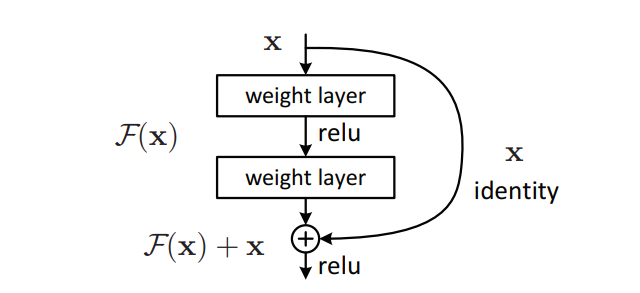

In [24]:
def resnet_block(inputs, filters = 16, kernel = 3, strides = 1, activation = 'relu', batch_normalization = True, conv_first = True):

  conv = Conv2D(filters, kernel_size=kernel, strides=strides, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001))

  x = inputs

  if conv_first:
    x = conv(x)
    if batch_normalization:
      x = BatchNormalization()(x)
    if activation is not None:
      x = Activation(activation)(x)
  else:
    if batch_normalization:
      x = BatchNormalization()(x)
    if activation is not None:
      x = Activation(activation)(x)
    x = conv(x)
  
  return x

# Implementation of the complete model

In [25]:
def resnet(input_shape, depth, num_classes=10):

  if (depth - 2) % 6 != 0:
    raise ValueError('depth -> 6n+2')
  
  filters = 16
  no_res_blocks = int((depth-2)/6)

  inputs = Input(shape=input_shape)
  x = resnet_block(inputs=inputs)

  for stack in range(3):
    for res_block in range(no_res_blocks):
      strides = 1
      if stack > 0 and res_block == 0:
        strides = 2
      
      y = resnet_block(inputs=x, filters=filters, kernel=1, strides=strides, activation=None, batch_normalization=False)
      y = resnet_block(inputs=y, filters=filters, activation=None)

      if stack > 0 and res_block == 0:
        x = resnet_block(inputs=x, filters=filters, kernel=1, strides=strides, activation=None, batch_normalization=False)

      x = tf.keras.layers.add([x, y])
      x = Activation('relu')(x)

    filters *= 2

  x = AveragePooling2D(pool_size=8)(x)

  y = Flatten()(x)

  outputs = Dense(classes, activation='softmax', kernel_initializer='he_normal')(y)

  model = Model(inputs=inputs, outputs=outputs)

  return model

# Constructing the model and model summary

In [26]:
input_shape = x_train.shape[1:]
# print(input_shape)

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

if subtract_pixel_mean:
  x_train_mean = np.mean(x_train, axis=0)
  x_train -=  x_train_mean
  x_test -= x_train_mean

y_train = tf.keras.utils.to_categorical(y_train, classes)
y_test = tf.keras.utils.to_categorical(y_test, classes)

model = resnet(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=lr_schedule(0)), metrics=['accuracy'])

model.summary() 

Learning rate =  0.001
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 32, 32, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 32, 32, 16)   64          conv2d_21[0][0]                  
__________________________________________________________________________________________________
activation_10 (Activation)      (None, 32, 32, 16)   0           batch_normalization_10[0][0]     
_____________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


# Training the model

In [27]:
start_time = time.time()

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)

callbacks = [lr_reducer, lr_scheduler]

datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation 
        # (strictly between 0 and 1)
        validation_split=0.0)

# Compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

# Fit the model on the batches generated by datagen.flow().
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),validation_data=(x_test, y_test),epochs=epochs, verbose=0, workers=1,callbacks=callbacks, use_multiprocessing=False)
    

Learning rate =  0.001
Learning rate =  0.001
Learning rate =  0.001
Learning rate =  0.001
Learning rate =  0.001
Learning rate =  0.001
Learning rate =  0.001
Learning rate =  0.001
Learning rate =  0.001
Learning rate =  0.001
Learning rate =  0.001
Learning rate =  0.001
Learning rate =  0.001
Learning rate =  0.001
Learning rate =  0.001
Learning rate =  0.001
Learning rate =  0.001
Learning rate =  0.001
Learning rate =  0.001
Learning rate =  0.001
Learning rate =  0.001
Learning rate =  0.0001
Learning rate =  0.0001
Learning rate =  0.0001
Learning rate =  0.0001
Learning rate =  0.0001
Learning rate =  0.0001
Learning rate =  0.0001
Learning rate =  0.0001
Learning rate =  0.0001
Learning rate =  0.0001
Learning rate =  1e-05
Learning rate =  1e-05
Learning rate =  1e-05
Learning rate =  1e-05
Learning rate =  1e-05
Learning rate =  1e-05
Learning rate =  1e-05
Learning rate =  1e-05
Learning rate =  1e-05
Learning rate =  1e-05
Learning rate =  1e-06
Learning rate =  1e-06
L

In [29]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 20s 65ms/step - loss: 0.5779 - accuracy: 0.8544
Test loss: 0.5778741240501404
Test accuracy: 0.8543999791145325


# Training and Validation losses

# Training and Validation Accuracy

In [36]:
history.history

{'accuracy': [0.47457998991012573,
  0.5982999801635742,
  0.6548799872398376,
  0.6887000203132629,
  0.7115200161933899,
  0.7277399897575378,
  0.7412199974060059,
  0.750819981098175,
  0.7603999972343445,
  0.7677800059318542,
  0.7725399732589722,
  0.7782400250434875,
  0.7841200232505798,
  0.791159987449646,
  0.793179988861084,
  0.7939199805259705,
  0.8012999892234802,
  0.8033599853515625,
  0.8056600093841553,
  0.808459997177124,
  0.8125399947166443,
  0.8429200053215027,
  0.8529599905014038,
  0.8574000000953674,
  0.8622599840164185,
  0.8606399893760681,
  0.8633000254631042,
  0.8644400238990784,
  0.8652399778366089,
  0.8675600290298462,
  0.870199978351593,
  0.8725600242614746,
  0.8724600076675415,
  0.8727800250053406,
  0.8739200234413147,
  0.8756999969482422,
  0.8766000270843506,
  0.8759999871253967,
  0.8741199970245361,
  0.8762000203132629,
  0.874779999256134,
  0.8767600059509277,
  0.8761199712753296,
  0.876579999923706,
  0.8757799863815308,
  0.